https://app.dominodatalab.com/u/fonnesbeck/gp_showdown/view/GP+Showdown.ipynb

In [5]:
import re
import numpy as np
import pandas as pd

In [6]:
GPXfile='Lunch_Walk.gpx'
data = open(GPXfile).read()

In [57]:
lat = np.array(re.findall(r'lat="([^"]+)',data),dtype=float)
lon = np.array(re.findall(r'lon="([^"]+)',data),dtype=float)
time = re.findall(r'<time>([^\<]+)',data)
dt = pd.to_datetime(time)
s = dt.astype(int)

coords = np.array(list(zip(lat,lon,time,dt,s)))


coords = coords[::1]
coords[5]


coords.shape

(6614, 5)

In [58]:
import gpflow
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 3)

(1.0, 2.6953561689665615, 0.0, -1.8507733689807204, (6614, 1), (6614, 1))

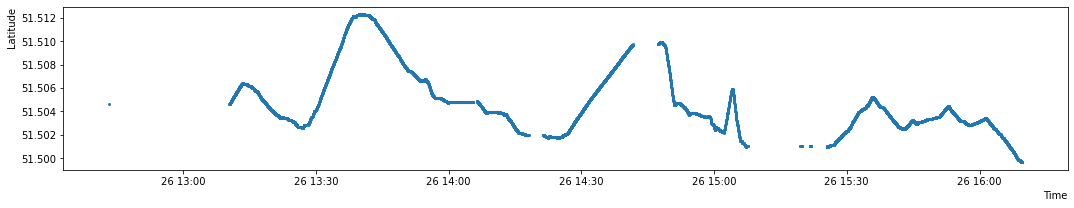

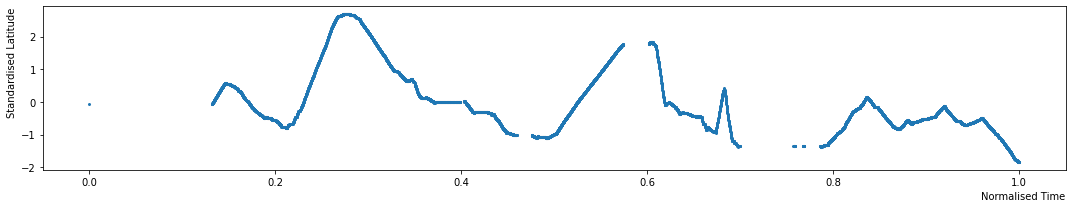

In [111]:
X = coords[:, -2].reshape(-1, 1)
Xsec = coords[:, -1].reshape(-1, 1).astype(np.float64)




Y = coords[:, 0].reshape(-1, 1).astype(np.float64)


plt.figure(figsize=(18,3))
_ = plt.plot(X, Y, ".", mew=.005)
plt.xlabel('Time', horizontalalignment='right', x=1.0)
plt.ylabel('Latitude', horizontalalignment='right', y=1.0)
# plt.tight_layout()


#centre time data - Cholesky decomposition was not successful.
Xm = Xsec.mean()
Xs = Xsec.std()

# Xsec = (Xsec - Xsec.mean()) / Xsec.std()
Xsec -= Xsec.min()
Xsec /= Xsec.max()

Ym = Y.mean()
Ys = Y.std()
Y = (Y - Y.mean()) / Y.std()

plt.figure(figsize=(15,3))

_ = plt.plot(Xsec, Y, ".", mew=.005)
plt.xlabel('Normalised Time', horizontalalignment='right', x=1.0)
plt.ylabel('Standardised Latitude', horizontalalignment='right', y=1.0)
plt.tight_layout()
# plt.figure()

# Y = coords[:, 1].reshape(-1, 1)
# _ = plt.plot(X, Y, ".", mew=.005)
# plt.title('Lon')

'''

Centering (and 'whitening' i.e. unit standard deviation) is equivalent to changing the hyperparameter settings. If you whiten the data then the gpflow defaults are probably going to be ok, but if you don't whiten they the hyperparameters can be grossly misspecified and you may have an ill-conditioned problem. If you do not whiten the data then you need to be more careful about hyperparameter initialization.
'''
Xsec.max(),Y.max(),Xsec.min(),Y.min(),Xsec.shape,Y.shape

# kernel = gpflow.kernels.Matern52()
kernel = gpflow.kernels.Matern52( variance=1, lengthscales=1.2) 
#+ gpflow.kernels.Matern32( variance=1, lengthscales=1.2) 

# from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
# kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)
'''
A GP kernel can be specified as the sum of additive components in scikit-learn simply by using the sum operator, so we can include a Matèrn component (Matern), an amplitude factor (ConstantKernel), as well as an observation noise (WhiteKernel):
'''

m = gpflow.models.GPR(data=(Xsec, Y), kernel=kernel, mean_function=None)
m.trainable_variables

m.likelihood.variance.assign(0.01)
# m.kernel.lengthscales.assign(0.3)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
print_summary(m)

## generate test points for prediction
npoints = 100
xx = np.linspace(np.min(Xsec), np.max(Xsec), npoints).reshape(npoints, 1).astype(np.float64)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)



## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.clf()
plt.figure()
# plt.plot(Xsec, Y, "kx", mew=2)
plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)




plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)


plt.plot(Xsec, Y,'k+',mew=.84 ,c = 'coral' )


# _ = plt.xlim(-0.1, 1.1)

Adaptive sample style

In [30]:
coords


array([[51.504613, -0.141894, '2020-12-26T12:43:14Z',
        Timestamp('2020-12-26 12:43:14+0000', tz='UTC'),
        1608986594000000000],
       [51.504624, -0.141901, '2020-12-26T13:10:26Z',
        Timestamp('2020-12-26 13:10:26+0000', tz='UTC'),
        1608988226000000000],
       [51.504633, -0.141906, '2020-12-26T13:10:28Z',
        Timestamp('2020-12-26 13:10:28+0000', tz='UTC'),
        1608988228000000000],
       ...,
       [51.499653, -0.141922, '2020-12-26T16:09:33Z',
        Timestamp('2020-12-26 16:09:33+0000', tz='UTC'),
        1608998973000000000],
       [51.49966, -0.141926, '2020-12-26T16:09:35Z',
        Timestamp('2020-12-26 16:09:35+0000', tz='UTC'),
        1608998975000000000],
       [51.499661, -0.141926, '2020-12-26T16:09:37Z',
        Timestamp('2020-12-26 16:09:37+0000', tz='UTC'),
        1608998977000000000]], dtype=object)

In [301]:

Y = coords[:, 0].reshape(-1, 1).astype(np.float64)
X = coords[:, -1].reshape(-1, 1).astype(np.float64)

second = 1000000000

resolution = 0.0008
timegap = 60*second


Xarr = []
Yarr = []
Yold = -999
Xold = -999
for j,i in enumerate(Y):
    if abs(i-Yold)>resolution:
        Yarr.append(i)
        Yold=i
        Xold = X[j]
        Xarr.append(X[j])
    elif abs(X[j]-Xold)>timegap:
        Yarr.append(i)
        Yold=i
        Xold = X[j]
        Xarr.append(X[j])
        
        
len(Yarr)

Xarr= np.array(Xarr).reshape(-1, 1).astype(np.float64)
Yarr= np.array(Yarr).reshape(-1, 1).astype(np.float64)


Xarr -= Xarr.min()
Xarr /= Xarr.max()


scale = 1/Yarr.std()
Yarr*=scale#1/resolution
Ym = Yarr.mean()
Yarr -= Yarr.mean()
# Yarr*=100#1/resolution

# Ym = Yarr.mean()
# Ys = Yarr.std()
# Yarr = (Yarr - Yarr.mean()) / Yarr.std()

len(Yarr)

164

In [302]:
kernel =  gpflow.kernels.Matern52( variance=1, lengthscales=1.2)+ gpflow.kernels.White() #+gpflow.kernels.Exponential() 

m = gpflow.models.GPR(data=(Xarr, Yarr), kernel=kernel, mean_function=None)
m.trainable_variables

m.likelihood.variance.assign(0.01)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.780264    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.0185008   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ 

<Figure size 864x216 with 0 Axes>

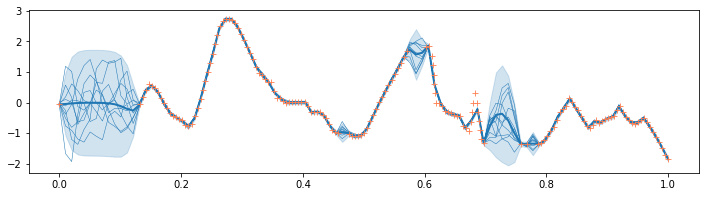

In [303]:
## generate test points for prediction
npoints = 100
xx = np.linspace(np.min(Xarr), np.max(Xarr), npoints).reshape(npoints, 1).astype(np.float64)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.clf()
plt.figure()

# y2 = (Y - Ym) / Ys




plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)

# plt.plot(Xsec, y2,linewidth=.51,c='red')
plt.plot(Xarr, Yarr,'k+',mew=.84 ,c = 'coral' )
# 



<Figure size 864x216 with 0 Axes>

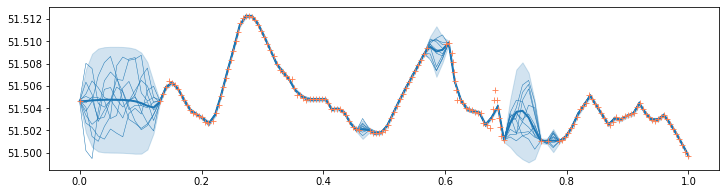

In [304]:
## generate test points for prediction
npoints = 100
xx = np.linspace(np.min(Xarr), np.max(Xarr), npoints).reshape(npoints, 1).astype(np.float64)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

# mean*=resolution
mean += Ym
mean/=scale

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

samples += Ym
samples/=scale

var/=scale**2

## plot
plt.clf()
plt.figure()

# y2 = (Y - Ym) / Ys




plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)

# plt.plot(Xsec, y2,linewidth=.51,c='red')
plt.plot(Xarr, ((Yarr)+Ym)/scale,'k+',mew=.84 ,c = 'coral' )
# 




In [305]:
Y.min(),Y.max()

(51.499633, 51.512325)